# Imports

In [2]:
from cytoflow import *
import os

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math
from tqdm.notebook import tqdm

from matplotlib.lines import Line2D

mpl.rcParams["font.sans-serif"] = "Helvetica"
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["pdf.fonttype"] = 42
sns.set_style(
    "ticks",
    {
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "font_color": "k",
        "axes.edgecolor": "k",
        "xtick.color": "k",
        "ytick.color": "k",
    },
)
sns.set_context("talk", font_scale=1.0)

# Setting up the plate

In [6]:
plasmid_dict = {
    126: "rTetR-only",
    217: "ZNF10-only",
    222: "FOXO3-only",
    56: "STaPL-only",
    140:"FOXO3-ZNF10",
    73: "FOXO3-STaPL-ZNF10",
}

plasmid_list = [126, 217, 222, 56, 140, 73]

In [7]:
columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
rows = ["A", "B", "C", "D", "E", "F", "G", "H"]


def get_fcs(plasmid, dox, asv, replicate):
    dirname = "./fcs/axm-20220421_stapl_mincmv-20220421-1833/"
    column = columns[plasmid_list.index(plasmid) + 6 * (dox != 0)]
    row = rows[2 * (asv == 1) + 1 * (replicate == 2)]
    return dirname + row + str(column) + ".fcs"

# Importing Tubes

In [23]:
tubeslist = []

for dox in [0, 1000]:
    for asv in [0, 1]:
        for replicate in [1, 2]:
            for plasmid in plasmid_list:
                tubeslist.extend(
                    [
                        Tube(
                            conditions={
                                "plasmid": plasmid,
                                "description": plasmid_dict[plasmid],
                                "dox": dox,
                                "asv": asv,
                                "replicate": replicate,
                            },
                            file=get_fcs(plasmid, dox, asv, replicate),
                            conditions_list=[
                                "plasmid",
                                "description",
                                "dox",
                                "asv",
                                "replicate",
                            ],
                        )
                    ]
                )
                
print("Loaded", len(tubeslist), "tubes")

Loaded 48 tubes


In [25]:
def get_ex_0(tube):
    op_0 = ImportOp(
        conditions={
            "plasmid" : "category",
            "description" : "category",
            "dox" : "float",
            "asv" : "float",
            "replicate" : "float"
        },
        tubes=[tube],
        channels={
            "mCitrine-A": "mCitrine-A",
            "mCherry-A": "mCherry-A",
            "FSC 488/10-A": "FSC 488/10-A",
            "SSC 488/10-A": "SSC 488/10-A",
        },
    )
    ex_0 = op_0.apply()
    return ex_0


ex_0_list = [get_ex_0(t) for t in tqdm(tubeslist)]
all_data = pd.concat([e.data for e in tqdm(ex_0_list)])
ex_0 = ex_0_list[0]
ex_0.data = all_data
ex_0.data.head()

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

,FSC 488/10-A,SSC 488/10-A,asv,description,dox,mCherry-A,mCitrine-A,plasmid,replicate
0,669108224.0,198535936.0,0.0,rTetR-only,0.0,191138048.0,2103808.0,126,1.0
1,595002112.0,279674368.0,0.0,rTetR-only,0.0,200646400.0,2106112.0,126,1.0
2,422279424.0,126640896.0,0.0,rTetR-only,0.0,152885504.0,1572608.0,126,1.0
3,422191104.0,376752384.0,0.0,rTetR-only,0.0,10576128.0,6055168.0,126,1.0
4,338533120.0,186644992.0,0.0,rTetR-only,0.0,82312704.0,1349120.0,126,1.0


# Live cells, mCherry gating

CPU times: user 5.99 s, sys: 962 ms, total: 6.95 s
Wall time: 3.41 s


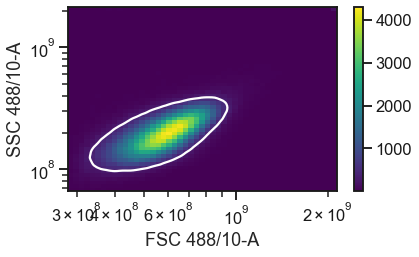

In [28]:
%%time

dens_op = DensityGateOp(
    name="P1",
    xchannel="FSC 488/10-A",
    xscale="log",
    ychannel="SSC 488/10-A",
    yscale="log",
    keep=0.9,
)

dens_op.estimate(ex_0)
ex_1 = dens_op.apply(ex_0)
dens_op.default_view().plot(ex_0, height=4)

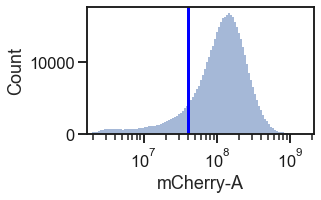

In [29]:
op_2 = ThresholdOp(name="mCherry", threshold=4e7, channel="mCherry-A")
ex_2 = op_2.apply(ex_1)
op_2.default_view(subset="(P1==True)", scale="log").plot(ex_2)

In [30]:
all_cells = ex_2.data
all_cells = all_cells[(all_cells['P1'])&(all_cells['mCherry'])]
all_cells.to_csv('./data/all_cells_mch_live.csv', index=False)
all_cells

,FSC 488/10-A,SSC 488/10-A,asv,description,dox,mCherry-A,mCitrine-A,plasmid,replicate,P1,mCherry
0,669108224.0,198535936.0,0.0,rTetR-only,0.0,191138048.0,2103808.0,126,1.0,True,True
1,595002112.0,279674368.0,0.0,rTetR-only,0.0,200646400.0,2106112.0,126,1.0,True,True
2,422279424.0,126640896.0,0.0,rTetR-only,0.0,152885504.0,1572608.0,126,1.0,True,True
4,338533120.0,186644992.0,0.0,rTetR-only,0.0,82312704.0,1349120.0,126,1.0,True,True
5,496757248.0,205096960.0,0.0,rTetR-only,0.0,104084480.0,1945344.0,126,1.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...
14025,673896448.0,222614528.0,1.0,FOXO3-STaPL-ZNF10,1000.0,85921536.0,5757696.0,73,2.0,True,True
14026,463902720.0,159699712.0,1.0,FOXO3-STaPL-ZNF10,1000.0,58426112.0,2525184.0,73,2.0,True,True
14027,416357632.0,133082368.0,1.0,FOXO3-STaPL-ZNF10,1000.0,95832832.0,3575808.0,73,2.0,True,True
14028,554682368.0,139582720.0,1.0,FOXO3-STaPL-ZNF10,1000.0,60224512.0,1680640.0,73,2.0,True,True


# Drawing histograms and computing fractions

In [3]:
all_cells = pd.read_csv('./data/all_cells_mch_live.csv')
all_cells = all_cells[all_cells["plasmid"] != 140]

all_cells["Citrine On"] = all_cells["mCitrine-A"] > 1e7
gdf = all_cells.groupby(["plasmid", "description", "dox", "asv"]).mean().reset_index()
gdf = gdf[["plasmid", "description", "dox", "asv", "Citrine On"]]
gdf

,plasmid,description,dox,asv,Citrine On
0,56,STaPL-only,0.0,0.0,0.001020
1,56,STaPL-only,0.0,1.0,0.000588
2,56,STaPL-only,1000.0,0.0,0.000878
3,56,STaPL-only,1000.0,1.0,0.000787
4,73,FOXO3-STaPL-ZNF10,0.0,0.0,0.000492
5,73,FOXO3-STaPL-ZNF10,0.0,1.0,0.000641
6,73,FOXO3-STaPL-ZNF10,1000.0,0.0,0.875863
7,73,FOXO3-STaPL-ZNF10,1000.0,1.0,0.031894
8,126,rTetR-only,0.0,0.0,0.000425
9,126,rTetR-only,0.0,1.0,0.001337


In [4]:
def plot_histograms(px, ax):
    pdf = all_cells[all_cells["plasmid"] == px]

    sns.kdeplot(
        data=pdf[pdf["dox"] == 0],
        x="mCitrine-A",
        color="#999999",
        fill=False,
        log_scale=True,
        common_norm=False,
        ax=ax,
    )

    sns.kdeplot(
        data=pdf[pdf["dox"] == 1000],
        x="mCitrine-A",
        hue="asv",
        palette=["#70cc33", "#2c7fb8"],
        fill=True,
        legend=False,
        log_scale=True,
        common_norm=False,
        ax=ax,
    )

    ax.set_yticks([])
    ax.set_ylim([0, 4])
    ax.set_xlim(5e5, 5e9)
    ax.set_xticks([1e6, 1e7, 1e8, 1e9])
    ax.set_ylabel("")

    qdf = gdf[gdf["plasmid"] == px]
    pasv_on = qdf[(qdf["dox"] == 1000) & (qdf["asv"] == 1)]
    pasv_on = list(pasv_on["Citrine On"])[0]
    masv_on = qdf[(qdf["dox"] == 1000) & (qdf["asv"] == 0)]
    masv_on = list(masv_on["Citrine On"])[0]

    ax.axvline(1e7, ymin=0, ymax=2, color="#444444", linestyle="--")

    ax.text(2e7, 3, "{:.0f}".format(pasv_on * 100) + "% On", color="#2c7fb8")
    ax.text(2e7, 1.75, "{:.0f}".format(masv_on * 100) + "% On", color="#70cc33")

    ax.set_title(plasmid_dict[px])

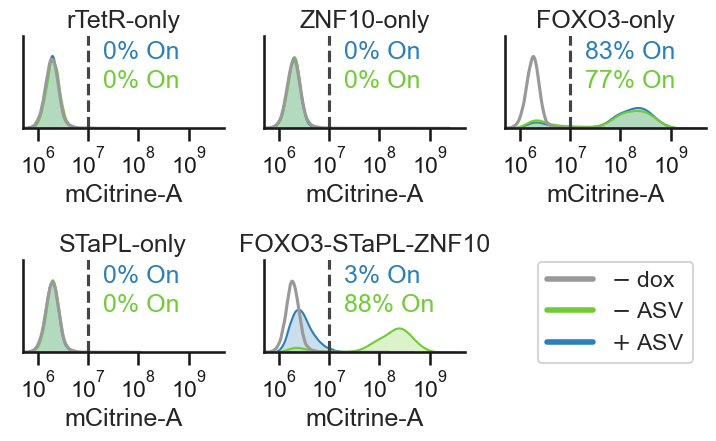

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(7.5, 4.75))

for i, ax in enumerate(axes.flat[:-1]):
    plot_histograms([126, 217, 222, 56, 73][i], ax)

axes.flat[-1].set_visible(False)

sns.despine(fig)
plt.tight_layout()
# fig.suptitle("STaPL Testing at minCMV", y=1.1)

custom_lines = [
    Line2D([0], [0], color="#999999", lw=4),
    Line2D([0], [0], color="#70cc33", lw=4),
    Line2D([0], [0], color="#2c7fb8", lw=4),
]
axes.flat[0].legend(
    custom_lines,
    ["$\minus$ dox", "$\minus$ ASV", "$\plus$ ASV"],
    loc="center left",
    bbox_to_anchor=(2.5, -2),
)

fig.savefig("./plots/stapl_cmv_summary.pdf", bbox_inches="tight")
fig.savefig("./plots/stapl_cmv_summary.png", dpi=600)

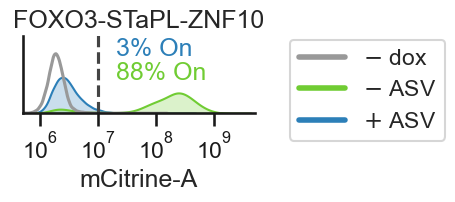

In [19]:
fig, ax = plt.subplots(figsize=(3, 1))

plot_histograms(73, ax)

sns.despine(fig)

custom_lines = [
    Line2D([0], [0], color="#999999", lw=4),
    Line2D([0], [0], color="#70cc33", lw=4),
    Line2D([0], [0], color="#2c7fb8", lw=4),
]
ax.legend(
    custom_lines,
    ["$\minus$ dox", "$\minus$ ASV", "$\plus$ ASV"],
    loc="center left",
    bbox_to_anchor=(1.1, 0.3),
)

plt.savefig("./plots/stapl_cmv_73.pdf", bbox_inches="tight")